In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt

import parmed as pmd
import pytraj as pt
import numpy as np
import paprika
print('version: '+paprika.__version__)
from paprika import align
from paprika import tleap
from paprika import dummy
from paprika import restraints
from paprika import analysis
from paprika import amber
from paprika import utils
import os
import sys
import shutil
import re

import logging as log
reload(log)
log.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                filename='log.Notebook', level=log.DEBUG)
log.debug('test')

version: 2018-04-17_18:30:26_-0700-48718cc-0.0.3


In [2]:
### Some initial CB8 stuff

# tleap command lines that build your structure
tleap_lines = [
    'source leaprc.water.tip3p',
    'loadamberparams ions.frcmod',
    'loadamberparams hst.frcmod',
    'HST = loadmol2 hst.mol2',
    'loadamberparams gst.frcmod',
    'GST = loadmol2 gst.mol2',
    'loadamberparams dummy.frcmod',
    'DM1 = loadmol2 dm1.mol2',
    'DM2 = loadmol2 dm2.mol2',
    'DM3 = loadmol2 dm3.mol2',
    'model = loadpdb hst-gst-dum.pdb',
]

tleap_build_files = ['ions.frcmod', 'hst.mol2','hst.frcmod','gst.mol2','gst.frcmod',
                     'dummy.frcmod', 'dm1.mol2', 'dm2.mol2', 'dm3.mol2']

guest_mask = ':GST'
host_oxy_side1 = ':HST@O9,O10,O11,O12,O13,O14,O15,O16'
host_oxy_side2 = ':HST@O1,O2,O3,O4,O5,O6,O7,O8'

# Anchor atoms
host_anch  = [':HST@C2', ':HST@C8', ':HST@C16']
guest_anch = [':GST@C17', ':GST@N2']
dummy_anch = [':DM1', ':DM2', ':DM3']

# Guest restraint details
attach_fractions = [0.0000, 0.0040, 0.0080, 0.0160, 0.0240, 0.0400, 0.0550, 0.0865, 0.1180, 0.1810, 0.2440, 0.3700, 0.4960, 0.7480, 1.0000]
num_attach_windows = len(attach_fractions)
attach_dist_fc = 5.0 # kcal/mol-Angstrom**2
attach_dist_target = 6.0 # Angstrom
pull_dist_target = 24.0 # Angstrom
pull_dist_incr = 0.4 # Angstrom
num_pull_windows = int(1. + (pull_dist_target-attach_dist_target)/pull_dist_incr )
attach_ang_fc = 100 # kcal/mol-rad**2
attach_ang_target = 180.0 # degrees
pull_ang_target = 180.0 # degrees
num_release_windows = 0

In [3]:
# Process each CB8/G3 conformation: align, write pdb, mol2, frcmod
hg_parms = []
for i_conf in range(5):
    conf_name = 'CB8-G3-'+str(i_conf)
    
    # Make directory
    if not os.path.isdir(conf_name):
        os.makedirs(conf_name)
    
    # Load pmd AmberParm
    prmtop = '../SAMPL6/host_guest/SAMPLing/'+conf_name+'/AMBER/complex.prmtop'
    rst7 = '../SAMPL6/host_guest/SAMPLing/'+conf_name+'/AMBER/complex.rst7'
    pmd_parm = pmd.amber.AmberParm(prmtop, xyz=rst7)
    
    # Align by CB8 oxygens. note conf 3 is reversed.
    hg_parm = pmd_parm[':HST,GST']
    if i_conf == 3:
        hg_parm = align.zalign(hg_parm, host_oxy_side2, host_oxy_side1)
    else:
        hg_parm = align.zalign(hg_parm, host_oxy_side1, host_oxy_side2)
    hg_parm.save(conf_name+'/hst-gst.pdb', overwrite=True)
    # Add dummy atoms
    hg_parm = dummy.add_dummy(hg_parm, residue_name='DM1', z=-3.500)
    hg_parm = dummy.add_dummy(hg_parm, residue_name='DM2', z=-6.500)
    hg_parm = dummy.add_dummy(hg_parm, residue_name='DM3', z=-8.700, y=2.200)
    hg_parm.save(conf_name+'/hst-gst-dum.pdb', overwrite=True)
    hg_parms.append(hg_parm)
    
    # Save mol2/frcmods for Host, Guest, and Ions
    for subsys in ['hst','gst','ions']:
        if subsys == 'ions':
            mask = '!:HST,GST,WAT'
        else:
            mask = ':'+subsys.upper()
        subsys_parm = pmd_parm[mask]
        subsys_parm.save(conf_name+'/'+subsys+'.mol2', overwrite=True)
        parmset = pmd.amber.AmberParameterSet.from_structure(subsys_parm)
        parmset.write(conf_name+'/'+subsys+'.frcmod')
        
    # Write mol2/frcmod files for dummy
    dummy.write_dummy_frcmod(filepath=conf_name+'/dummy.frcmod')
    dummy.write_dummy_mol2(filepath=conf_name+'/dm1.mol2', residue_name='DM1')
    dummy.write_dummy_mol2(filepath=conf_name+'/dm2.mol2', residue_name='DM2')
    dummy.write_dummy_mol2(filepath=conf_name+'/dm3.mol2', residue_name='DM3')

        

![title](cb8-g3-aligned.png)

In [4]:
# Setup host restraints. Make a sublist for each conformation.
# Some format of this should become a function ...

host_rests = []

for i_conf in range(5):
    host_rests.append([])

    # Translational Distance
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[0], host_anch[0]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_dist_fc,
        amber_index=True
    ))

    # Translational Angle
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[1], dummy_anch[0], host_anch[0]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Translational Torsion
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[2], dummy_anch[1], dummy_anch[0], host_anch[0]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Orientational Angle 1
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[0], host_anch[0], host_anch[1]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Orientational Torsion 1
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[1], dummy_anch[0], host_anch[0], host_anch[1]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Orientational Torsion 2
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[0], host_anch[0], host_anch[1], host_anch[2]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))


In [5]:
# Setup guest restraints

guest_rests = []

for i_conf in range(5):
    guest_rests.append([]) 
    
    # Guest Translational Distance
    guest_rests[i_conf].append(restraints.DAT_restraint())
    guest_rests[i_conf][-1].auto_apr = True
    guest_rests[i_conf][-1].amber_index = True
    guest_rests[i_conf][-1].topology = hg_parms[i_conf]
    guest_rests[i_conf][-1].mask1 = dummy_anch[0]
    guest_rests[i_conf][-1].mask2 = guest_anch[0]
    guest_rests[i_conf][-1].attach['target'] = attach_dist_target
    guest_rests[i_conf][-1].attach['fraction_list'] = attach_fractions
    guest_rests[i_conf][-1].attach['fc_final'] = attach_dist_fc
    guest_rests[i_conf][-1].pull['target_final'] = pull_dist_target
    guest_rests[i_conf][-1].pull['num_windows'] = num_pull_windows
    guest_rests[i_conf][-1].initialize()

    # Guest Translational Angle
    guest_rests[i_conf].append(restraints.DAT_restraint())
    guest_rests[i_conf][-1].auto_apr = True
    guest_rests[i_conf][-1].amber_index = True
    guest_rests[i_conf][-1].topology = hg_parms[i_conf]
    guest_rests[i_conf][-1].mask1 = dummy_anch[1]
    guest_rests[i_conf][-1].mask2 = dummy_anch[0]
    guest_rests[i_conf][-1].mask3 = guest_anch[0]
    guest_rests[i_conf][-1].attach['target'] = attach_ang_target
    guest_rests[i_conf][-1].attach['fraction_list'] = attach_fractions
    guest_rests[i_conf][-1].attach['fc_final'] = attach_ang_fc
    guest_rests[i_conf][-1].pull['target_final'] = pull_ang_target
    guest_rests[i_conf][-1].pull['num_windows'] = num_pull_windows
    guest_rests[i_conf][-1].initialize()

    # Guest Orientational Angle
    guest_rests[i_conf].append(restraints.DAT_restraint())
    guest_rests[i_conf][-1].auto_apr = True
    guest_rests[i_conf][-1].amber_index = True
    guest_rests[i_conf][-1].topology = hg_parms[i_conf]
    guest_rests[i_conf][-1].mask1 = dummy_anch[0]
    guest_rests[i_conf][-1].mask2 = guest_anch[0]
    guest_rests[i_conf][-1].mask3 = guest_anch[1]
    guest_rests[i_conf][-1].attach['target'] = attach_ang_target
    guest_rests[i_conf][-1].attach['fraction_list'] = attach_fractions
    guest_rests[i_conf][-1].attach['fc_final'] = attach_ang_fc
    guest_rests[i_conf][-1].pull['target_final'] = pull_ang_target
    guest_rests[i_conf][-1].pull['num_windows'] = num_pull_windows
    guest_rests[i_conf][-1].initialize()

# Make window list
window_list = restraints.create_window_list(guest_rests[0])

In [6]:
# Create solvated systems and restraints file
phase_dict = {'a': 'attach', 'p': 'pull', 'r': 'release'}

for i_conf in range(5):
    conf_path = 'CB8-G3-'+str(i_conf)
    
    # Create windows
    utils.make_window_dirs(window_list, path=conf_path, stash_existing=False)
    
    for win in window_list:
        win_path = os.path.join(conf_path,'windows',win)
        phase = phase_dict[win[0]]
        
        # Write restraints.in files
        with open(os.path.join(win_path,'restraints.in'), 'w') as f:
                for rest in host_rests[i_conf]+guest_rests[i_conf]:
                    f.write(restraints.amber_restraint_line(rest,phase,int(win[1:])))
                    
        # Translate guest in z-axis to starting position
        target_diff = guest_rests[i_conf][0].phase[phase]['targets'][int(win[1:])] \
                      - guest_rests[i_conf][0].pull['target_initial']
        
        struct = pmd.load_file(os.path.join(conf_path,'hst-gst-dum.pdb'))
        for atom in struct:
            if atom.residue.name == guest_mask[1:]:
                atom.xz += target_diff

        # Write out PDB for tleap
        struct.write_pdb(os.path.join(win_path,'hst-gst-dum.trans.pdb'), renumber=False)
        
        # Copy build files
        for build_file in tleap_build_files:
            shutil.copy(os.path.join(conf_path,build_file), win_path)
            
        # Create vacuum prmtop/rst7
        tlp_sys = tleap.System()
        tlp_sys.template_lines = tleap_lines
        tlp_sys.output_path = win_path
        tlp_sys.output_prefix = 'vac'
        tlp_sys.pbc_type = None
        tlp_sys.loadpdb_file = 'hst-gst-dum.trans.pdb'
        if not os.path.isfile(os.path.join(win_path,'vac.prmtop')):
            tlp_sys.build()

        # Create solvated prmtop/rst7
        tlp_sys.pbc_type = 'rectangular'
        tlp_sys.target_waters = 2500
        tlp_sys.neutralize = True
        tlp_sys.add_ions = ['Na+', 6, 'Cl-', 6]
        tlp_sys.output_prefix = 'solvated'
        if not os.path.isfile(os.path.join(win_path,'solvated.prmtop')):
            tlp_sys.build()
            

![title](cb8-g3-solv.png)

<IPython.core.display.Javascript object>


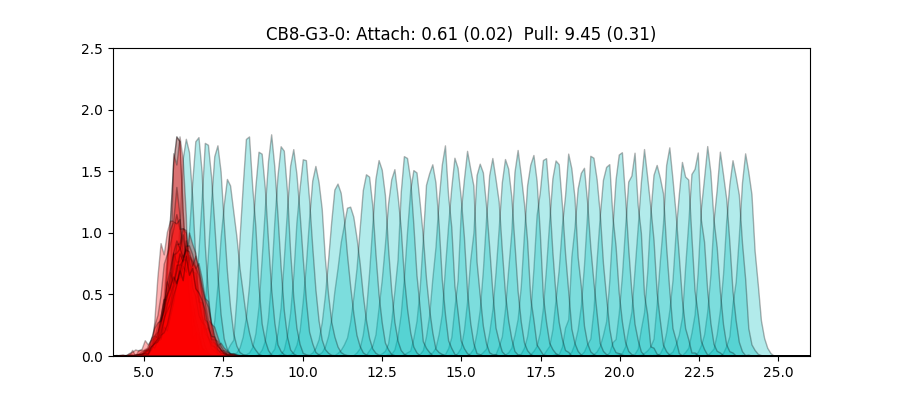

----- prev :000 cur: 001 -----

CB8-G3-0: Attach: 9.00 (0.37)  Pull: 9.43 (0.62)
----- prev :001 cur: 002 -----
a000 a001 a002 a003 a004 a005 a006 a007 a008 a009 a010 a011 
CB8-G3-0: Attach: 0.62 (0.02)  Pull: 9.43 (0.62)
----- prev :002 cur: 003 -----

----- prev :003 cur: 004 -----

----- prev :004 cur: 005 -----

----- prev :005 cur: 006 -----

----- prev :006 cur: 007 -----

----- prev :007 cur: 008 -----

----- prev :008 cur: 009 -----
p008 p009 p010 p011 p012 p013 p014 p015 p016 p017 p018 p019 p020 p021 p022 p023 p024 p025 p026 p027 p028 p029 p030 p031 p032 p033 p034 p035 p036 p037 p038 p039 p040 p041 p042 p043 p044 p045 
CB8-G3-0: Attach: 0.61 (0.02)  Pull: 8.97 (0.45)
----- prev :009 cur: 010 -----
p000 p001 p002 p003 p004 p005 p006 p007 p008 p009 p010 p011 p012 p013 p014 p015 p016 p017 p018 p019 p020 p025 p026 
CB8-G3-0: Attach: 0.61 (0.02)  Pull: 8.33 (0.50)
----- prev :010 cur: 011 -----
p001 p002 p003 p004 p005 p007 p008 p009 p010 p011 p012 p013 p014 p015 p016 p017 
CB8-G3-

In [ ]:
#Run Simulations

# Setup plot
fig,axs = plt.subplots(figsize=(9,4))
axis = [4.0,26.0,0.0,2.5]
zorder = len(window_list)+2

# Converence threshold, kcal/mol (probably need separate for attach vs. pull)
convergence_thresh = {'attach': 0.006, 'pull': 0.03}
# Simulation steps per iteration
itr_nstlim = 500000

# Loop through conformations
for i_conf in range(5):
    conf_path = 'CB8-G3-'+str(i_conf)

    # Store simulations here
    sim_list = []
    # Convergence check
    all_converged = {'attach': None, 'pull': None, 'release': None}
    
    # Loop of restart iterations
    for itr in range(50):
        # Checker for whether new data has been generated
        # Start with assumption of no new data
        new_data = False

        # Strings for restart iterations
        prev = "{:03.0f}".format(itr)
        curr = "{:03.0f}".format(itr+1)

        print('----- prev :'+prev+' cur: '+curr+' -----')
        sys.stdout.flush()

        # Loop through windows
        for i_win,win in enumerate(window_list):
            # Create some useful variables
            phase = phase_dict[win[0]]
            win_path = os.path.join(conf_path,'windows/'+win+'/')

            # If first time through, create simulation class and minimize
            if itr == 0:
                sim = amber.Simulation()
                sim_list.append(sim)
                sim.executable = 'pmemd.cuda'
                sim.path = win_path
                sim.topology = 'solvated.prmtop'
                sim.prefix = 'minimize'
                sim.inpcrd = 'solvated.rst7'
                sim.ref = 'solvated.rst7'
                sim.config_pbc_min()
                sim.cntrl['maxcyc'] = 500
                sim.cntrl['ncyc'] = 400
                sim.cntrl['ntr'] = 1
                sim.cntrl['restraint_wt'] = 50.0
                sim.cntrl['restraintmask'] = "'@DUM'"
                # This might be an overwrite run, so check if minimize is done already
                if not os.path.isfile(win_path+'/minimize.rst7'):
                    sim.run()

                # Run Equilibration ... if we terminate early due to
                # box size changes, continue on from restart
                sim.config_pbc_md()
                sim.executable = 'pmemd.cuda'
                sim.cntrl['nstlim'] = itr_nstlim
                sim.cntrl['ntwx'] = 250
                sim.cntrl['ntwprt'] = 196
                sim.cntrl['ntwr'] = 250
                i = 0
                sim.prefix = 'equil.'+str(i)
                sim.inpcrd = 'minimize.rst7'
                sim.ref = 'solvated.rst7'
                # Run equil loop until we complete a full equil cycle.
                # Then copy the final rst7 to 'equil.rst7'
                while not os.path.isfile(win_path+'/equil.rst7') and i < 10:
                    if not os.path.isfile(win_path+'/'+sim.inpcrd):
                        break
                    sim.run()
                    with open(win_path+'/equil.'+str(i)+'.out') as f:
                        for line in f.readlines():
                            if re.search(' TIMINGS', line):
                                shutil.copy(win_path+'/'+sim.restart, win_path+'/equil.rst7')
                    i += 1
                    sim.prefix = 'equil.'+str(i)
                    sim.inpcrd = 'equil.'+str(i-1)+'.rst7'
                    sim.ref = 'solvated.rst7'

            # Setup production MD
            if itr == 0:
                sim.config_pbc_md()
                sim.executable = 'pmemd.cuda'
                sim.prefix = 'prod.'+curr
                #sim.input = 'mdin'
                sim.inpcrd = 'equil.rst7'
                sim.ref = 'solvated.rst7'
                sim.cntrl['ntx'] = 5
                sim.cntrl['irest'] = 1
                sim.cntrl['nstlim'] = itr_nstlim
                sim.cntrl['ntwr'] = itr_nstlim
                sim.cntrl['ntwx'] = 250
                sim.cntrl['ntwprt'] = 196
                sim.cntrl['ntxo'] = 2
                if not os.path.isfile(win_path+'/'+sim.restart):
                    sim.run()
                    new_data = True
                # From now on, don't assume we can access sim. Use
                # sim_list[i_win] instead. The reason is we aren't
                # gonna keep setting sim up each time and we've stored
                # them in sim_list
                sim = None            
            else:
                sim_list[i_win].prefix = 'prod.'+curr
                sim_list[i_win].inpcrd = 'prod.'+prev+'.rst7'
                sim_list[i_win].ref = 'solvated.rst7'
                #sim_list[i_win].input = 'mdin'
                # Check convergence to decide if we are "converged"
                convergence_val = fecalc.results[phase]['mbar-block']['convergence'][int(win[1:])]
                if convergence_val < convergence_thresh[phase]:
                    sim_list[i_win].converged = True
                if not sim_list[i_win].converged and not os.path.isfile(win_path+'/'+sim_list[i_win].restart):
                    sys.stdout.write(win+' ')
                    sim_list[i_win].run()
                    new_data = True
        print('')            
        
        # Collect data and compute free energy                   
        if itr == 0 or new_data:
            fecalc = analysis.fe_calc()
            fecalc.prmtop = 'vac.prmtop'
            fecalc.trajectory = 'prod.*.nc'
            fecalc.path = os.path.join(conf_path,'windows')
            fecalc.restraint_list = guest_rests[i_conf]
            fecalc.collect_data()
            fecalc.compute_free_energy()
            print('{}: Attach: {:.2f} ({:.2f})  Pull: {:.2f} ({:.2f})'.format(
                conf_path,
                fecalc.results['attach']['mbar-block']['fe'],
                fecalc.results['attach']['mbar-block']['sem'],
                fecalc.results['pull']['mbar-block']['fe'],
                fecalc.results['pull']['mbar-block']['sem'],
            ))

        # Check overall Convergence
        for phase in "attach pull".split():
            convergence_vals = np.array(fecalc.results[phase]['mbar-block']['convergence'])
            if (convergence_vals < 0.05).all():
                all_converged[phase] = True
            else:
                all_converged[phase] = False
        
        # Update our plot.
        axs.clear()
        axs.axis(axis)
        axs.set_title('{}: Attach: {:.2f} ({:.2f})  Pull: {:.2f} ({:.2f})'.format(
            conf_path,
            fecalc.results['attach']['mbar-block']['fe'],
            fecalc.results['attach']['mbar-block']['sem'],
            fecalc.results['pull']['mbar-block']['fe'],
            fecalc.results['pull']['mbar-block']['sem'],
        ))
        for phase in 'attach pull'.split():                    
            for i in range(len(fecalc.simulation_data[phase])):
                hist,bins = np.histogram(
                                fecalc.simulation_data[phase][i][0],
                                bins=301,
                                range=(0,30),
                                density=True
                            )
                center = (bins[:-1] + bins[1:]) / 2
                if phase == 'attach':
                    facecolor = 'r'
                else:
                    facecolor = 'c'
                axs.fill_between(
                    center, hist*0.0, hist, facecolor=facecolor, edgecolor='k',
                    alpha=0.3, zorder=zorder
                )
                zorder -= 1
            fig.canvas.draw()
            
        # If all phases are converged, we're done!
        if not False in all_converged.values():
            print("Done!")
            break

        sys.stdout.flush()

